In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from math import exp
import re

- Import data.

In [2]:
type_df = pd.read_csv('../data/csv/ShakespeareCharacterLines_play_corpus.csv', index_col = ['play'])

In [3]:
char_df = pd.read_csv('../data/csv/ShakespeareCharacterLines_character_corpus.csv', index_col = ['play', 'name'])

In [4]:
colon = slice(None)

- Redo train/test splits and PCA.

In [5]:
char_xlist = char_df.columns.tolist()
char_xlist.remove('character_dies')

char_X = char_df[char_xlist]
char_y = char_df['character_dies']

smt = SMOTE(random_state = 42, k_neighbors = 25, n_jobs = -1)
char_Xsm, char_ysm = smt.fit_resample(char_X, char_y)

char_X_train, char_X_test, char_y_train, char_y_test = \
train_test_split(char_X, char_y, random_state = 42, stratify = char_y, test_size = .2)

char_Xsm_train, char_Xsm_test, char_ysm_train, char_ysm_test = \
train_test_split(char_Xsm, char_ysm, random_state = 42, stratify = char_ysm, test_size = .2)

sc = StandardScaler()

char_Xs_train = sc.fit_transform(char_X_train)
char_Xs_test = sc.transform(char_X_test)
char_Xs = sc.transform(char_X)

char_Xsms_train = sc.fit_transform(char_Xsm_train)
char_Xsms_test = sc.transform(char_Xsm_test)
char_Xsms = sc.transform(char_Xsm)

In [6]:
type_xlist = type_df.columns.tolist()
type_xlist.remove('play_type')

type_X = type_df[type_xlist]
type_y = type_df['play_type']

type_X_train, type_X_test, type_y_train, type_y_test = \
train_test_split(type_X, type_y, random_state = 42, stratify = type_y, test_size = .2)

sc = StandardScaler()

type_Xs_train = sc.fit_transform(type_X_train)
type_Xs_test = sc.transform(type_X_test)
type_Xs = sc.transform(type_X)

In [7]:
pca_sm = PCA(random_state=42, n_components=1114)
char_Zsms_train = pca_sm.fit_transform(char_Xsms_train)
char_Zsms_test = pca_sm.transform(char_Xsms_test)

- Import inferential models.

In [8]:
char_inf_mnb = pickle.load(open('../models/CharMultinomialNaiveBayes.pkl', 'rb'))

In [9]:
type_inf_pred_logreg = pickle.load(open('../models/TypeLogisticRegression.pkl', 'rb'))

- Import predictive models.

In [10]:
char_pred_svc = pickle.load(open('../models/CharPCASVC.pkl', 'rb'))

- Create sorted lists of inferential model weights.

- Character deaths:

In [11]:
char_weights = {}

In [12]:
char_weights_dies = zip(char_inf_mnb.feature_log_prob_[1], char_X.columns)

In [13]:
char_weights_dies = {key: exp(value) for value, key in char_weights_dies}

In [14]:
char_weights['dies'] = {k: v for k, v in sorted(char_weights_dies.items(), key=lambda item: item[1], reverse=True)}

In [15]:
char_weights_lives = zip(char_inf_mnb.feature_log_prob_[0], char_X.columns)

In [16]:
char_weights_lives = {key: exp(value) for value, key in char_weights_lives}

In [17]:
char_weights['lives'] = {k: v for k, v in sorted(char_weights_lives.items(), key=lambda item: item[1], reverse=True)}

- Play types:

In [18]:
type_weights = {}

In [19]:
def quick_tag(type_number, type_name):
    type_weights_next = zip(type_inf_pred_logreg.coef_[type_number], type_X.columns)
    type_weights_next = {key: exp(value) for value, key in type_weights_next}
    type_weights[type_name] = {k: v for k, v in sorted(type_weights_next.items(), key=lambda item: item[1], reverse=True)}

In [20]:
play_types = [(0, 'comedy'), (1, 'history'), (2, 'tragedy')]

for number, type_name in play_types:
    quick_tag(number, type_name)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


- Identify the individuals that were incorrectly classified as dead.

In [21]:
fail_indices = []

test_preds = char_pred_svc.predict(char_Zsms_test)

i = 0
for index, value in char_ysm_test.to_dict().items():
    if value != test_preds.T[i]:
        fail_indices.append(index)
    i+=1
    
fail_indices

[901, 177, 1372, 498]

In [22]:
failures = char_Xsm.loc[fail_indices]

In [23]:
failures

,pos_sentiment_mean,neg_sentiment_mean,neu_sentiment_mean,compound_sentiment_mean,endowment_hyp_mean,hang_mean,VERB_mean,character_name_mean,PROPN_mean,shall_mean,...,mollification_std,guangzhou_syn_std,canton_std,distractedly_syn_std,distractedly_std,grade_std,deplore_std,convention_hyp_std,more_std,severs_std
901,0.153353,0.028059,0.818588,0.577962,0.0,0.0,0.941176,0.529412,0.647059,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.508000,0.000000,0.492000,0.738350,0.0,0.0,1.000000,1.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1372,0.000000,0.000000,1.000000,0.500000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.232556,0.099333,0.668222,0.570283,0.0,0.0,0.777778,1.555556,2.222222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
char_X[char_X['pos_sentiment_mean'] == failures.iloc[0]['pos_sentiment_mean']]

,,pos_sentiment_mean,neg_sentiment_mean,neu_sentiment_mean,compound_sentiment_mean,endowment_hyp_mean,hang_mean,VERB_mean,character_name_mean,PROPN_mean,shall_mean,...,mollification_std,guangzhou_syn_std,canton_std,distractedly_syn_std,distractedly_std,grade_std,deplore_std,convention_hyp_std,more_std,severs_std
play,name,,,,,,,,,,,,,,,,,,,,,
timon-of-athens,SECOND LORD,0.153353,0.028059,0.818588,0.577962,0.0,0.0,0.941176,0.529412,0.647059,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
char_X[char_X['compound_sentiment_mean'] == failures.iloc[1]['compound_sentiment_mean']]

,,pos_sentiment_mean,neg_sentiment_mean,neu_sentiment_mean,compound_sentiment_mean,endowment_hyp_mean,hang_mean,VERB_mean,character_name_mean,PROPN_mean,shall_mean,...,mollification_std,guangzhou_syn_std,canton_std,distractedly_syn_std,distractedly_std,grade_std,deplore_std,convention_hyp_std,more_std,severs_std
play,name,,,,,,,,,,,,,,,,,,,,,
the-two-noble-kinsmen,SECOND AND THIRD KNIGHTS,0.508,0.0,0.492,0.73835,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
char_X[char_X['bridge_mean'] == failures.iloc[2]['bridge_mean']]

,,pos_sentiment_mean,neg_sentiment_mean,neu_sentiment_mean,compound_sentiment_mean,endowment_hyp_mean,hang_mean,VERB_mean,character_name_mean,PROPN_mean,shall_mean,...,mollification_std,guangzhou_syn_std,canton_std,distractedly_syn_std,distractedly_std,grade_std,deplore_std,convention_hyp_std,more_std,severs_std
play,name,,,,,,,,,,,,,,,,,,,,,
henry-vi-part-1,GLANSDALE,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
char_X[char_X['pos_sentiment_mean'] == failures.iloc[3]['pos_sentiment_mean']]

,,pos_sentiment_mean,neg_sentiment_mean,neu_sentiment_mean,compound_sentiment_mean,endowment_hyp_mean,hang_mean,VERB_mean,character_name_mean,PROPN_mean,shall_mean,...,mollification_std,guangzhou_syn_std,canton_std,distractedly_syn_std,distractedly_std,grade_std,deplore_std,convention_hyp_std,more_std,severs_std
play,name,,,,,,,,,,,,,,,,,,,,,
henry-v,SALISBURY,0.232556,0.099333,0.668222,0.570283,0.0,0.0,0.777778,1.555556,2.222222,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Death odds

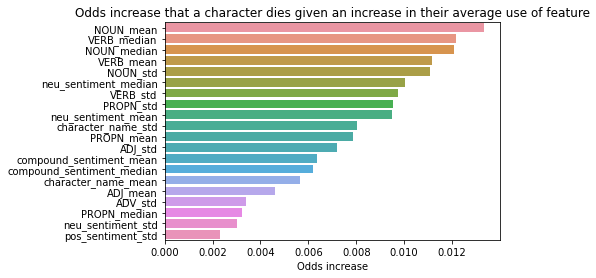

In [59]:
sns.barplot(x = list(char_weights['dies'].values())[:20], y = list(char_weights['dies'].keys())[:20])
plt.title("Odds increase that a character dies given an increase in their average use of feature")
plt.xlabel("Odds increase")
plt.savefig('../images/DeathOddsAll.png', bbox_inches='tight')
plt.show()

In [29]:
char_weights_words_dies = {key: value for key, value in char_weights['dies'].items() \
                           if re.search(r'[A-Z]|sentiment|character_name', key) == None}

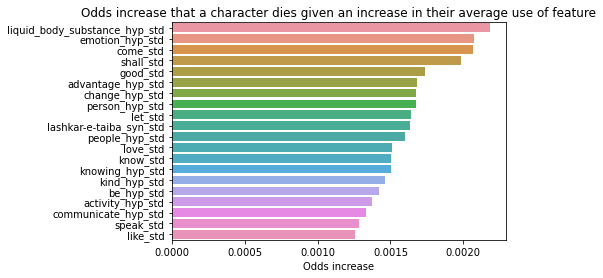

In [60]:
sns.barplot(x = list(char_weights_words_dies.values())[:20], y = list(char_weights_words_dies.keys())[:20])
plt.title("Odds increase that a character dies given an increase in their average use of feature")
plt.xlabel("Odds increase")
plt.savefig('../images/DeathOddsWords.png', bbox_inches='tight')
plt.show()

- Life odds.

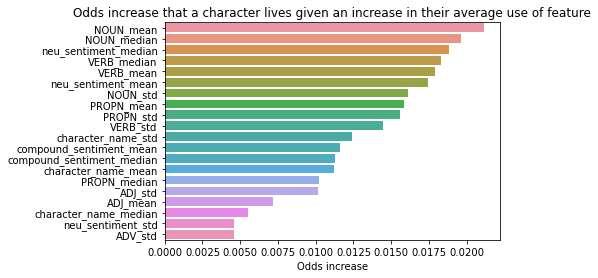

In [61]:
sns.barplot(x = list(char_weights['lives'].values())[:20], y = list(char_weights['lives'].keys())[:20])
plt.title("Odds increase that a character lives given an increase in their average use of feature")
plt.xlabel("Odds increase")
plt.savefig('../images/LifeOddsAll.png', bbox_inches='tight')
plt.show()

In [32]:
char_weights_words_lives = {key: value for key, value in char_weights['lives'].items() \
                           if re.search(r'[A-Z]|sentiment|character_name', key) == None}

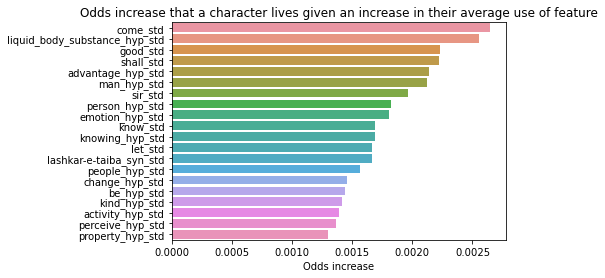

In [62]:
sns.barplot(x = list(char_weights_words_lives.values())[:20], y = list(char_weights_words_lives.keys())[:20])
plt.title("Odds increase that a character lives given an increase in their average use of feature")
plt.xlabel("Odds increase")
plt.savefig('../images/LifeOddsWords.png', bbox_inches='tight')
plt.show()

- Comedy odds

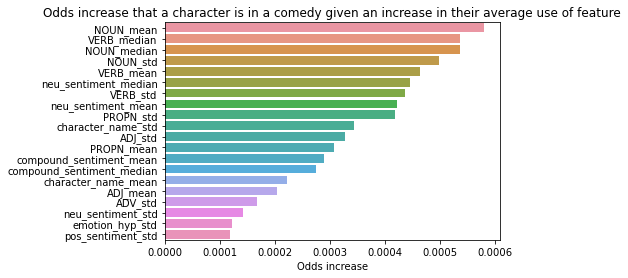

In [63]:
sns.barplot(x = list(type_weights['comedy'].values())[:20], y = list(type_weights['comedy'].keys())[:20])
plt.title("Odds increase that a character is in a comedy given an increase in their average use of feature")
plt.xlabel("Odds increase")
plt.savefig('../images/ComedyOddsAll.png', bbox_inches='tight')
plt.show()

In [35]:
type_weights_words_comedy = {key: value for key, value in type_weights['comedy'].items() \
                           if re.search(r'[A-Z]|sentiment|character_name', key) == None}

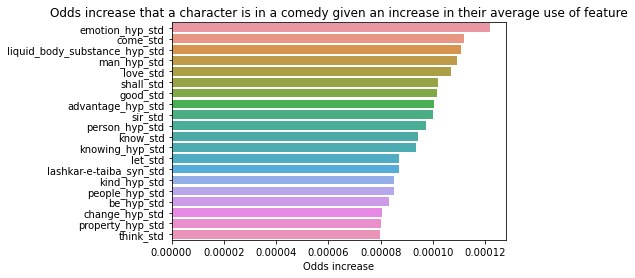

In [64]:
sns.barplot(x = list(type_weights_words_comedy.values())[:20], y = list(type_weights_words_comedy.keys())[:20])
plt.title("Odds increase that a character is in a comedy given an increase in their average use of feature")
plt.xlabel("Odds increase")
plt.savefig('../images/ComedyOddsWords.png', bbox_inches='tight')
plt.show()

- History odds.

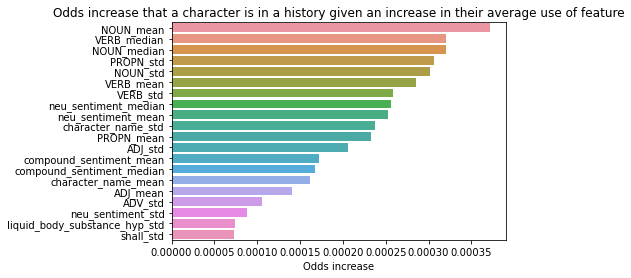

In [65]:
sns.barplot(x = list(type_weights['history'].values())[:20], y = list(type_weights['history'].keys())[:20])
plt.title("Odds increase that a character is in a history given an increase in their average use of feature")
plt.xlabel("Odds increase")
plt.savefig('../images/HistoryOddsAll.png', bbox_inches='tight')
plt.show()

In [38]:
type_weights_words_history = {key: value for key, value in type_weights['history'].items() \
                           if re.search(r'[A-Z]|sentiment|character_name', key) == None}

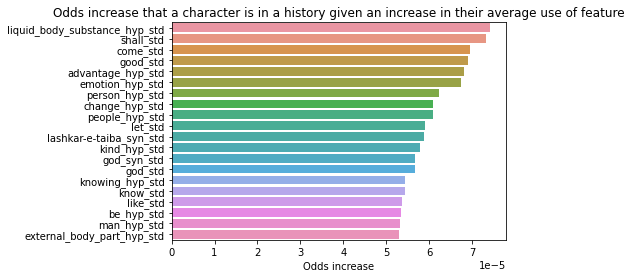

In [66]:
sns.barplot(x = list(type_weights_words_history.values())[:20], y = list(type_weights_words_history.keys())[:20])
plt.title("Odds increase that a character is in a history given an increase in their average use of feature")
plt.xlabel("Odds increase")
plt.savefig('../images/HistoryOddsWords.png', bbox_inches='tight')
plt.show()

- Tragedy odds.

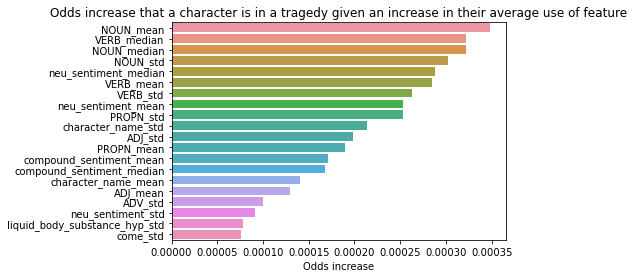

In [67]:
sns.barplot(x = list(type_weights['tragedy'].values())[:20], y = list(type_weights['tragedy'].keys())[:20])
plt.title("Odds increase that a character is in a tragedy given an increase in their average use of feature")
plt.xlabel("Odds increase")
plt.savefig('../images/TragedyOddsAll.png', bbox_inches='tight')
plt.show()

In [41]:
type_weights_words_tragedy = {key: value for key, value in type_weights['tragedy'].items() \
                           if re.search(r'[A-Z]|sentiment|character_name', key) == None}

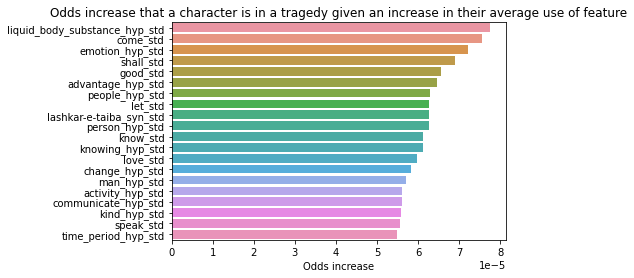

In [68]:
sns.barplot(x = list(type_weights_words_tragedy.values())[:20], y = list(type_weights_words_tragedy.keys())[:20])
plt.title("Odds increase that a character is in a tragedy given an increase in their average use of feature")
plt.xlabel("Odds increase")
plt.savefig('../images/TragedyOddsWords.png', bbox_inches='tight')
plt.show()